A notebook containing a minimum working example of the HSGP on synthetic data

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import gpflow
from gpflow.config import default_jitter
tf.config.run_functions_eagerly(True)


import ensembles as es
from ensembles import HSGP

2022-02-16 08:34:51.441581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 08:34:51.441614: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Generate pseudo data, consisting of 5 noisy 'realisations' from an underlying smooth function

2022-02-16 08:35:03.659383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-16 08:35:03.659410: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-16 08:35:03.659430: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ma-res-pinder): /proc/driver/nvidia/version does not exist


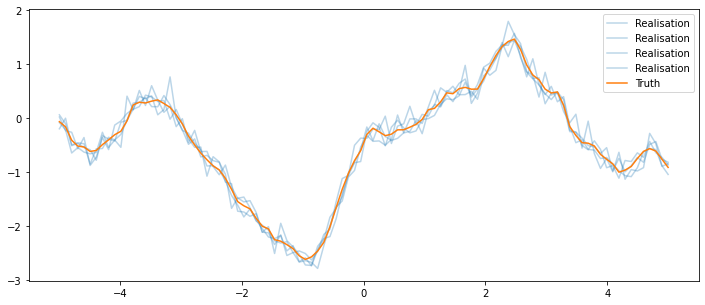

In [2]:
SEED = 30
rng = np.random.RandomState(SEED)
tfp_seed = tfp.random.sanitize_seed(SEED)

n_data = 100
n_realisations = 4
noise_limits = (0.1, 0.2)
xlims = (-5, 5)

X = np.linspace(*xlims, n_data).reshape(-1, 1)
true_kernel = gpflow.kernels.Matern32()
Kxx = true_kernel(X) + tf.cast(tf.eye(n_data)*default_jitter(), dtype=tf.float64)
latent_y = tfp.distributions.MultivariateNormalTriL(np.zeros(n_data), tf.linalg.cholesky(Kxx)).sample(seed=tfp_seed)

noise_terms = np.random.uniform(*noise_limits, size=n_realisations)
realisations = []

for noise in noise_terms:
    sample_y = latent_y.numpy() + rng.normal(loc=0., scale=noise, size=latent_y.numpy().shape)
    realisations.append(sample_y)
Y = np.asarray(realisations).T

plt.figure(figsize=(12, 5))
[plt.plot(X, r, alpha=0.3, color='tab:blue', label='Realisation') for r in realisations]
plt.plot(X, latent_y, color='tab:orange', label='Truth')
plt.legend()
plt.show()



In [20]:
np.minimum(1, 4)

1

Initialise the Hierarchical Sparse Gaussian Process (HSGP), providing the group and individual kernels, inducing points and data

In [3]:
data = (X, Y)

kernel = gpflow.kernels.Matern32()

n_inducing = 25
Z = np.linspace(*xlims, n_inducing).reshape(-1,1)

hsgp = HSGP(
    (X, Y),
    group_kernel=kernel,
    individual_kernel=kernel,
    inducing_points=Z)

gpflow.utilities.set_trainable(hsgp.inducing_points, False)

2022-02-16 08:35:18.617964: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Fit the HSGP

In [4]:
params = es.SGPRParameters().to_dict()
params['learning_rate'] = 0.1
params['optim_nits'] = 300
tf.config.run_functions_eagerly(False)
hsgp.fit(params)
tf.config.run_functions_eagerly(True)

100%|██████████| 300/300 [00:26<00:00, 11.28it/s]


Check convergence of the ELBO term

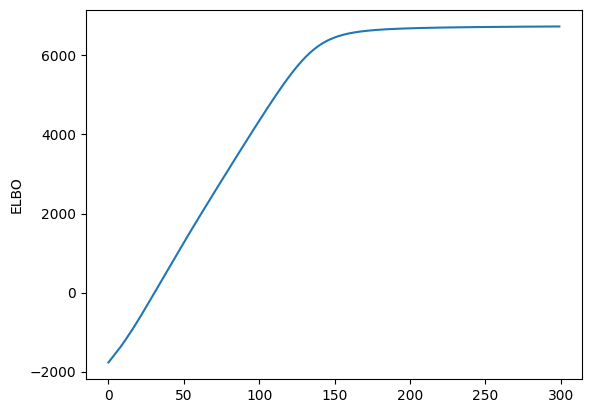

In [5]:
plt.figure()
plt.plot(-np.asarray(hsgp.objective_evals))
plt.ylabel('ELBO')
plt.show()

Look at fit for the individual realisations, given some test set of data

In [6]:
Xte = np.linspace(xlims[0] - 1, xlims[1] + 1, 500).reshape(-1, 1)
indi_preds = [hsgp.predict_individual(Xte, idx) for idx in range(n_realisations)]

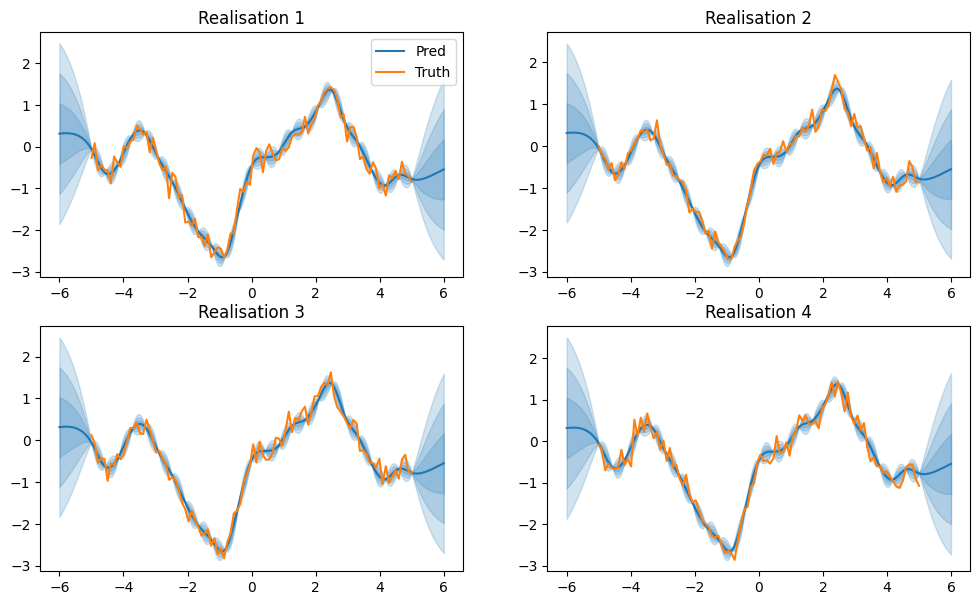

In [7]:
plt.figure(figsize=(12,7))
for i, indi_pred in enumerate(indi_preds):
    indi_mean, indi_var = indi_pred
    indi_mean = indi_mean.numpy().squeeze()
    indi_std = np.sqrt(indi_var.numpy().squeeze())
    x = X.squeeze()
    xte = Xte.squeeze()
    plt.subplot(2, 2, i + 1)
    plt.title(f'Realisation {i+1}')
    for j in range(1,4):
        plt.fill_between(xte, indi_mean - j * indi_std, indi_mean + j * indi_std, alpha=0.2, color='tab:blue')
    plt.plot(xte, indi_mean, label='Pred', color='tab:blue')
    plt.plot(x, Y[:, i], label='Truth', color='tab:orange')
    if i == 0:
        plt.legend()

plt.show()

What does the group prediction look like?

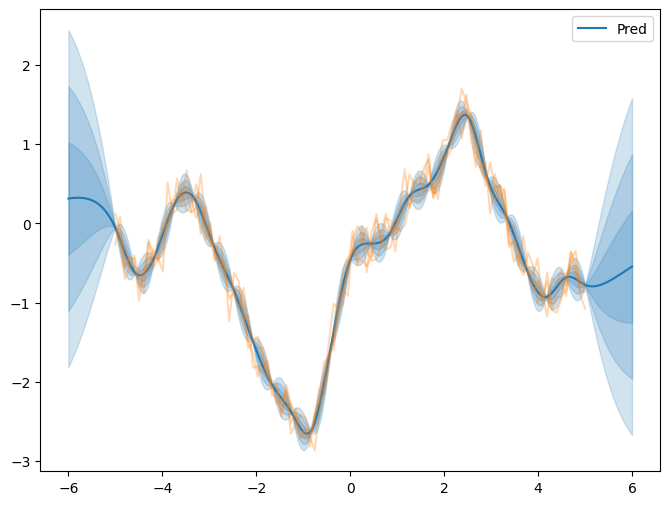

In [8]:
group_mean, group_var = hsgp.predict_group(Xte)
group_mean = group_mean.numpy().squeeze()
group_std = np.sqrt(group_var.numpy().squeeze())
x = X.squeeze()
xte = Xte.squeeze()

plt.figure(figsize=(8, 6))
for j in range(1,4):
    plt.fill_between(xte, group_mean - j * group_std, group_mean + j * group_std, alpha=0.2, color='tab:blue')
plt.plot(xte, group_mean, color='tab:blue', label='Pred') 
[plt.plot(x, r, alpha=0.3, color='tab:orange') for r in realisations]
plt.legend()
plt.show()

In [24]:
np.tile(np.linspace(-2., 2., 5), 5)

array([-2., -1.,  0.,  1.,  2., -2., -1.,  0.,  1.,  2., -2., -1.,  0.,
        1.,  2., -2., -1.,  0.,  1.,  2., -2., -1.,  0.,  1.,  2.])